In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from matplotlib.path import Path
%matplotlib inline

import numpy as np

from learning_utilities import *
from cell_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [3]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [4]:
surround_margins = range(100, 1100, 100)

In [5]:
labels_to_sample = structures + [l + '_negative' for l in structures] + \
[convert_to_surround_name(l, margin=m, suffix=surr_l) for m in surround_margins
 for l in structures for surr_l in structures + ['noclass'] if surr_l != l] + \
['noclass']

# Training

In [6]:
patch_size = 448
stride = 224
half_size = patch_size/2

In [7]:
import pandas

In [8]:
training_features = defaultdict(list)

for stack in all_annotated_stacks:
    first_sec, last_sec = metadata_cache['section_limits'][stack]
    s2f = metadata_cache['sections_to_filenames'][stack]
    grid_spec = (patch_size, stride, ) + metadata_cache['image_shape'][stack]
    
    for sec in range(first_sec, last_sec+1):
#     for sec in [205, 206]:
#         sys.stderr.write('%s, %d\n' % (stack, sec))
        
        if is_invalid(stack=stack, sec=sec):
            continue
            
        features_fp = get_cell_classifier_data_filepath(what='region_features', stack=stack, sec=sec, ext='pkl')
        region_features_all_regions = load_pickle(features_fp)
                
        features1 = np.asarray(region_features_all_regions['large_cell_orientation_hist'])
        features2 = np.asarray(region_features_all_regions['all_cell_size_weighted_hist'])        
        
        locations_fp = get_cell_classifier_data_filepath(what='region_locations', stack=stack, sec=sec, ext='txt')
        region_locations_all_regions = np.loadtxt(locations_fp, dtype=int)
        grid_indices_all_regions = region_locations_all_regions[:,0].tolist()
        
        patch_indices_df = locate_annotated_patches_v2(stack=stack, grid_spec=grid_spec, sections=[sec],
                                          surround_margins=[200, 500])
        
        for label, grid_indices in patch_indices_df[sec].iteritems():
            if len(grid_indices) == 0 or label in ['bg']:
                continue
                
            grid_indices_to_sample = np.random.choice(grid_indices, min(10, len(grid_indices)), replace=False)
            list_indices_to_sample = [grid_indices_all_regions.index(gi) for gi in grid_indices_to_sample]
            
#             sys.stderr.write('Sampled %d out of %d region for %s.\n' % (min(10, len(grid_indices)), len(grid_indices), label))
            
            feature1_n = features1[list_indices_to_sample]/features1[list_indices_to_sample].sum(axis=1)[:,None]
            feature2_n = features2[list_indices_to_sample]/features2[list_indices_to_sample].sum(axis=1)[:,None]
            
            concat_features = np.hstack([feature1_n, feature2_n])
            training_features[label].append(concat_features)
            
training_features = {label: np.concatenate(list_of_arrays) for label, list_of_arrays in training_features.iteritems()}

MD585, 205
Analyzing section 205..
2808 patches in fg
4 patches in RMC
32 patches in RtTg
0 patches in 10N
0 patches in Tz
148 patches in SC
33 patches in Pn
33 patches in IC
13 patches in 12N
1 patches in 4N
10 patches in RMC_surround_200_noclass
36 patches in RMC_surround_500_noclass
2804 patches in RMC_negative
30 patches in RtTg_surround_200_noclass
74 patches in RtTg_surround_500_noclass
7 patches in RtTg_surround_500_Pn
2776 patches in RtTg_negative
13 patches in 10N_surround_200_noclass
41 patches in 10N_surround_500_noclass
5 patches in 10N_surround_500_12N
2808 patches in 10N_negative
7 patches in Tz_surround_200_noclass
25 patches in Tz_surround_500_noclass
2808 patches in Tz_negative
47 patches in SC_surround_200_noclass
117 patches in SC_surround_500_noclass
6 patches in SC_surround_500_IC
2660 patches in SC_negative
21 patches in Pn_surround_200_noclass
49 patches in Pn_surround_500_noclass
5 patches in Pn_surround_500_RtTg
2775 patches in Pn_negative
29 patches in IC_surr

In [7]:
train_feat_dir = create_if_not_exists(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'training_features/'))

In [29]:
# Load training features

training_features = {}
for label in labels_to_sample:
    try:
        training_features[label] = bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))
    except:
        continue
        
labels_to_train = training_features.keys()
print labels_to_train

In [47]:
structures_to_train = {convert_to_original_name(l) for l in labels_to_train}
print structures_to_train

set(['RtTg'])


In [33]:
# negatives are surrounding patches that are not of other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 1

# negatives are surrounding patches (margin=200) that include other positive classes
# LogisticRegression(penalty='l2')
train_sample_scheme = 2
margin = 500

# negatives are surrounding patches that are not of other positive classes
# SVC(kernel='linear')
# train_sample_scheme = 3

# negatives are surrounding patches that are not of other positive classes
# LinearSVC(kernel='linear') + CalibratedClassifierCV
# train_sample_scheme = 4

# negatives are surrounding patches that are not of other positive classes
# XGBClassifier
# train_sample_scheme = 5

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=3, n_estimators=200
# train_sample_scheme = 6

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=5, n_estimators=100
# train_sample_scheme = 7

# negatives are all outside patches, including other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 8

# negatives are all outside patches, including other positive classes, weighted according to distance to the center of 
# the structure of interest.
# All surrounds are used as negative, other outside patches are randomly sampled to be negative.
# LogisticRegression(penalty='l2')
# train_sample_scheme = 9
# thresh = 1500
# def diminishing(x):
#     return np.exp(-(x-thresh)/3000.)

In [56]:
# train svm classifiers

clf_dir = create_if_not_exists(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'classifiers'))

for label in structures_to_train:
            
    print label

    t = time.time()

    features_pos = training_features[label]
    n_pos = len(features_pos)
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]
    elif train_sample_scheme == 2:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]        
        for surr_l in structures:
            c = convert_to_surround_name(label, margin=margin, suffix=surr_l)
            if c in labels_to_train:
                neg_classes.append(c)
    elif train_sample_scheme in [8,9]:
        neg_classes = [label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
    
    if train_sample_scheme == 9:
        neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    sys.stderr.write('%d, %d\n' % (n_pos, n_neg))
    
    ###########################################################################################

    train_data0 = np.r_[features_pos, features_neg]
    train_labels0 = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]

    train_data = train_data0
    train_labels = train_labels0
    
#     svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#           probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, 
#           max_iter=-1, decision_function_shape=None, random_state=None)

    if train_sample_scheme in [1, 8, 9]:
        # 1 - L2 penalty - train: 0.88, test acc: 0.84
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, clf_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 2:
        # L1 penalty - test acc: 0.818
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, clf_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

            
    elif train_sample_scheme == 3:
        # Slow - train acc: 0.69, test acc: 0.68
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, clf_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})


    elif train_sample_scheme == 4:
        # train 0.75, test 0.74
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, clf_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

        
    elif train_sample_scheme == 5:
        # train 
        
        # http://xgboost.readthedocs.io/en/latest/python/python_api.html
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(svc, clf_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 6:
        # acc: 0.96/0.85
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif train_sample_scheme == 7:
        # acc: 0.98/0.87
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('training scheme is not recognized.\n')
 
    sys.stderr.write('train classifier: %.2f seconds\n' % (time.time() - t))
    
    if train_sample_scheme == 9:
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
            
        clf.fit(train_data, train_labels, sample_weight=sample_weights)
    else:
        clf.fit(train_data, train_labels)
    
    joblib.dump(clf, clf_dir + '/%(label)s_clf_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

RtTg


70, 141
train classifier: 0.00 seconds


In [57]:
clf_allClasses = {}
for label in structures_to_train:
    clf_allClasses[label] = joblib.load(CELL_FEATURES_CLF_ROOTDIR + '/classifiers/%(label)s_clf_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

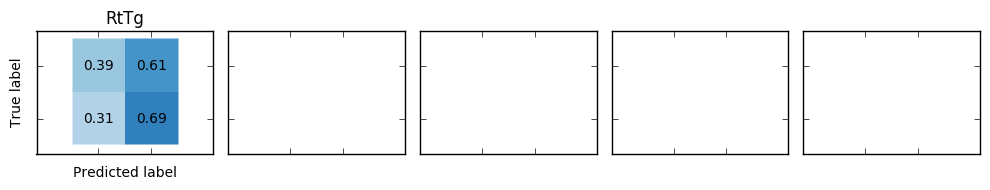

In [58]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_to_train)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, label in enumerate(structures_to_train):
    
    features_pos = training_features[label]
    n_pos = len(features_pos)
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]
    elif train_sample_scheme == 2:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]        
        for surr_l in structures:
            c = convert_to_surround_name(label, margin=margin, suffix=surr_l)
            if c in labels_to_train:
                neg_classes.append(c)
    elif train_sample_scheme in [8,9]:
        neg_classes = [label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = clf_allClasses[label]
    
    probs = svc.predict_proba(train_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[label] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [59]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.589752867534


In [ ]:
egion_features = {'all_cell_size_hist': all_cell_size_histogram_all_regions,
    'all_cell_size_weighted_hist': all_cell_size_weighted_histogram_all_regions,
    'large_cell_size_hist': large_cell_size_histogram_all_regions,
    'large_cell_orientation_hist': large_cell_orientation_histogram_all_regions,
    'neighbor_distance_hist': neighbor_distance_histogram_all_regions,
    'neighbor_direction_hist': neighbor_direction_histogram_all_regions,
    'large_cell_graph_neighbor_distance_hist': large_cell_graph_neighbor_distance_histogram_all_regions,
    'large_cell_graph_neighbor_direction_hist': large_cell_graph_neighbor_direction_histogram_all_regions,
    'large_small_cell_graph_neighbor_distance_hist': large_small_cell_graph_neighbor_distance_histogram_all_regions,
    'large_small_cell_graph_neighbor_direction_hist': large_